Import, Load and Clean Data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Load Data
df_train = pd.read_csv('tour_logs_train.csv')
df_test = pd.read_csv('tour_logs_test_input.csv')

# Cleaning Functions
def clean_price_robust(price_str):
    if pd.isna(price_str):
        return np.nan
    s = str(price_str).strip()
    multiplier = 1.0
    if '£' in s: multiplier = 1.27
    elif '€' in s: multiplier = 1.09

    matches = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    if matches:
        val = float(matches[0])
        if val < 0: val = abs(val)
        if val > 500: val = val / 10
        return val * multiplier
    return np.nan

# Apply Cleaning
df_train['Price_USD'] = df_train['Ticket_Price'].apply(clean_price_robust)
df_test['Price_USD'] = df_test['Ticket_Price'].apply(clean_price_robust)
df_train['Crowd_Energy'] = df_train['Crowd_Energy'].clip(0, 100)

print("Data Loaded and Cleaned.")



Data Loaded and Cleaned.


Exploratory Data Analysis

In [16]:
import scipy.stats as stats

# 1) Outlier Detection (Z-Score method)
def check_outliers_zscore(df, col_name, threshold=3):
    """
    Calculates Z-scores and prints rows that are > 3 std devs away from mean.
    """
    if col_name not in df.columns:
        print(f"Column '{col_name}' not found.")
        return

    # Drop NaNs just for calculation (Z-score needs clean numbers)
    series = df[col_name].dropna()

    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(series))

    # Get indices of outliers
    outlier_indices = series.index[z_scores > threshold]

    print(f"\n--- CHECKING OUTLIERS: '{col_name}' ---")
    print(f"Total Outliers Detected (Z > {threshold}): {len(outlier_indices)}")

    if len(outlier_indices) > 0:
        # Display the outlier values
        print(f"Indices: {outlier_indices.tolist()}")
        print("Sample Values:")
        print(df.loc[outlier_indices, [col_name]].head())
    else:
        print("No statistical outliers found.")

# --- RUN CHECKS ---
check_outliers_zscore(df_train, 'Price_USD')
check_outliers_zscore(df_train, 'Crowd_Size_Abs') # Checking the absolute size
if 'Volume_Level' in df_train.columns:
    check_outliers_zscore(df_train, 'Volume_Level')

# 2) Create "Clean Summary" DataFrame (Drop old messy columns)
cols_to_drop = [c for c in ['Ticket_Price', 'Date'] if c in df_train.columns]
df_clean_summary = df_train.drop(columns=cols_to_drop)

# --- DISPLAY SUMMARY ---
print("--- CLEANED DATA SUMMARY ---")
print(f"Shape: {df_clean_summary.shape}")

print("\n1. Data Info:")
df_clean_summary.info()

print("\n2. Statistical Summary (Numeric):")
# We use .T (transpose) to make it easier to read if there are many columns
print(df_clean_summary.describe().T)

print("\n3. First 5 Rows:")
print(df_clean_summary.head())

import pandas as pd

#3)  Missing Data Info
print("--- EVIDENCE OF MISSING DATA ---\n")

#-> Evidence: Why is 'Price_USD' missing?
# We look for rows where our cleaned 'Price_USD' is null
if 'Price_USD' in df_train.columns:
    missing_price = df_train[df_train['Price_USD'].isnull()]
    print(f"1. MISSING PRICES (Count: {len(missing_price)})")
    print("   Reason: Original 'Ticket_Price' contained text or invalid formats.")
    # Display the original 'Ticket_Price' to see what caused the issue
    print(missing_price[['Gig_ID', 'Ticket_Price']].head(5))
    print("-" * 40 + "\n")

#-> Evidence: Why is 'Show_DateTime' missing?
if 'Show_DateTime' in df_train.columns:
    missing_date = df_train[df_train['Show_DateTime'].isnull()]
    print(f"2. MISSING DATES (Count: {len(missing_date)})")
    print("   Reason: The 'Show_DateTime' column had no missing values in this dataset, but if it did, the reason might be vague text descriptions.")
    # Display the original 'Show_DateTime' to prove it
    print(missing_date[['Gig_ID', 'Show_DateTime']].head(5))
    print("-" * 40 + "\n")

#-> Evidence: Why is 'Volume_Level' missing?
# These are likely genuine missing values (sensor failures) as mentioned in the docs
if 'Volume_Level' in df_train.columns:
    missing_vol = df_train[df_train['Volume_Level'].isnull()]
    print(f"3. MISSING VOLUME (Count: {len(missing_vol)})")
    print("   Reason: Sensor failures (Null values in original file).")
    print(missing_vol[['Gig_ID', 'Venue_ID', 'Volume_Level']].head(5))
    print("-" * 40 + "\n")


--- CHECKING OUTLIERS: 'Price_USD' ---
Total Outliers Detected (Z > 3): 3
Indices: [437, 1312, 1334]
Sample Values:
      Price_USD
437      113.77
1312     113.11
1334     120.00
Column 'Crowd_Size_Abs' not found.

--- CHECKING OUTLIERS: 'Volume_Level' ---
Total Outliers Detected (Z > 3): 4
Indices: [463, 997, 1697, 1972]
Sample Values:
      Volume_Level
463           99.0
997           99.0
1697          99.0
1972          99.0
--- CLEANED DATA SUMMARY ---
Shape: (2000, 13)

1. Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gig_ID                 2000 non-null   object 
 1   Venue_ID               2000 non-null   object 
 2   Show_DateTime          2000 non-null   object 
 3   Day_of_Week            2000 non-null   int64  
 4   Volume_Level           1819 non-null   float64
 5   Crowd_Size             196

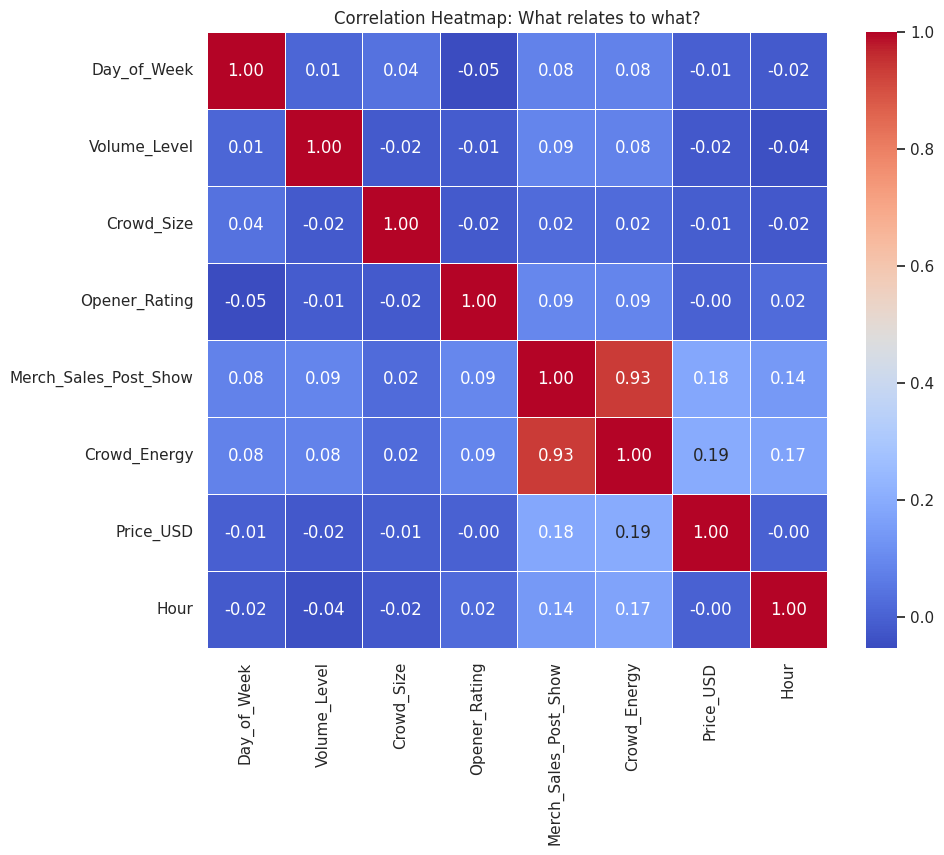

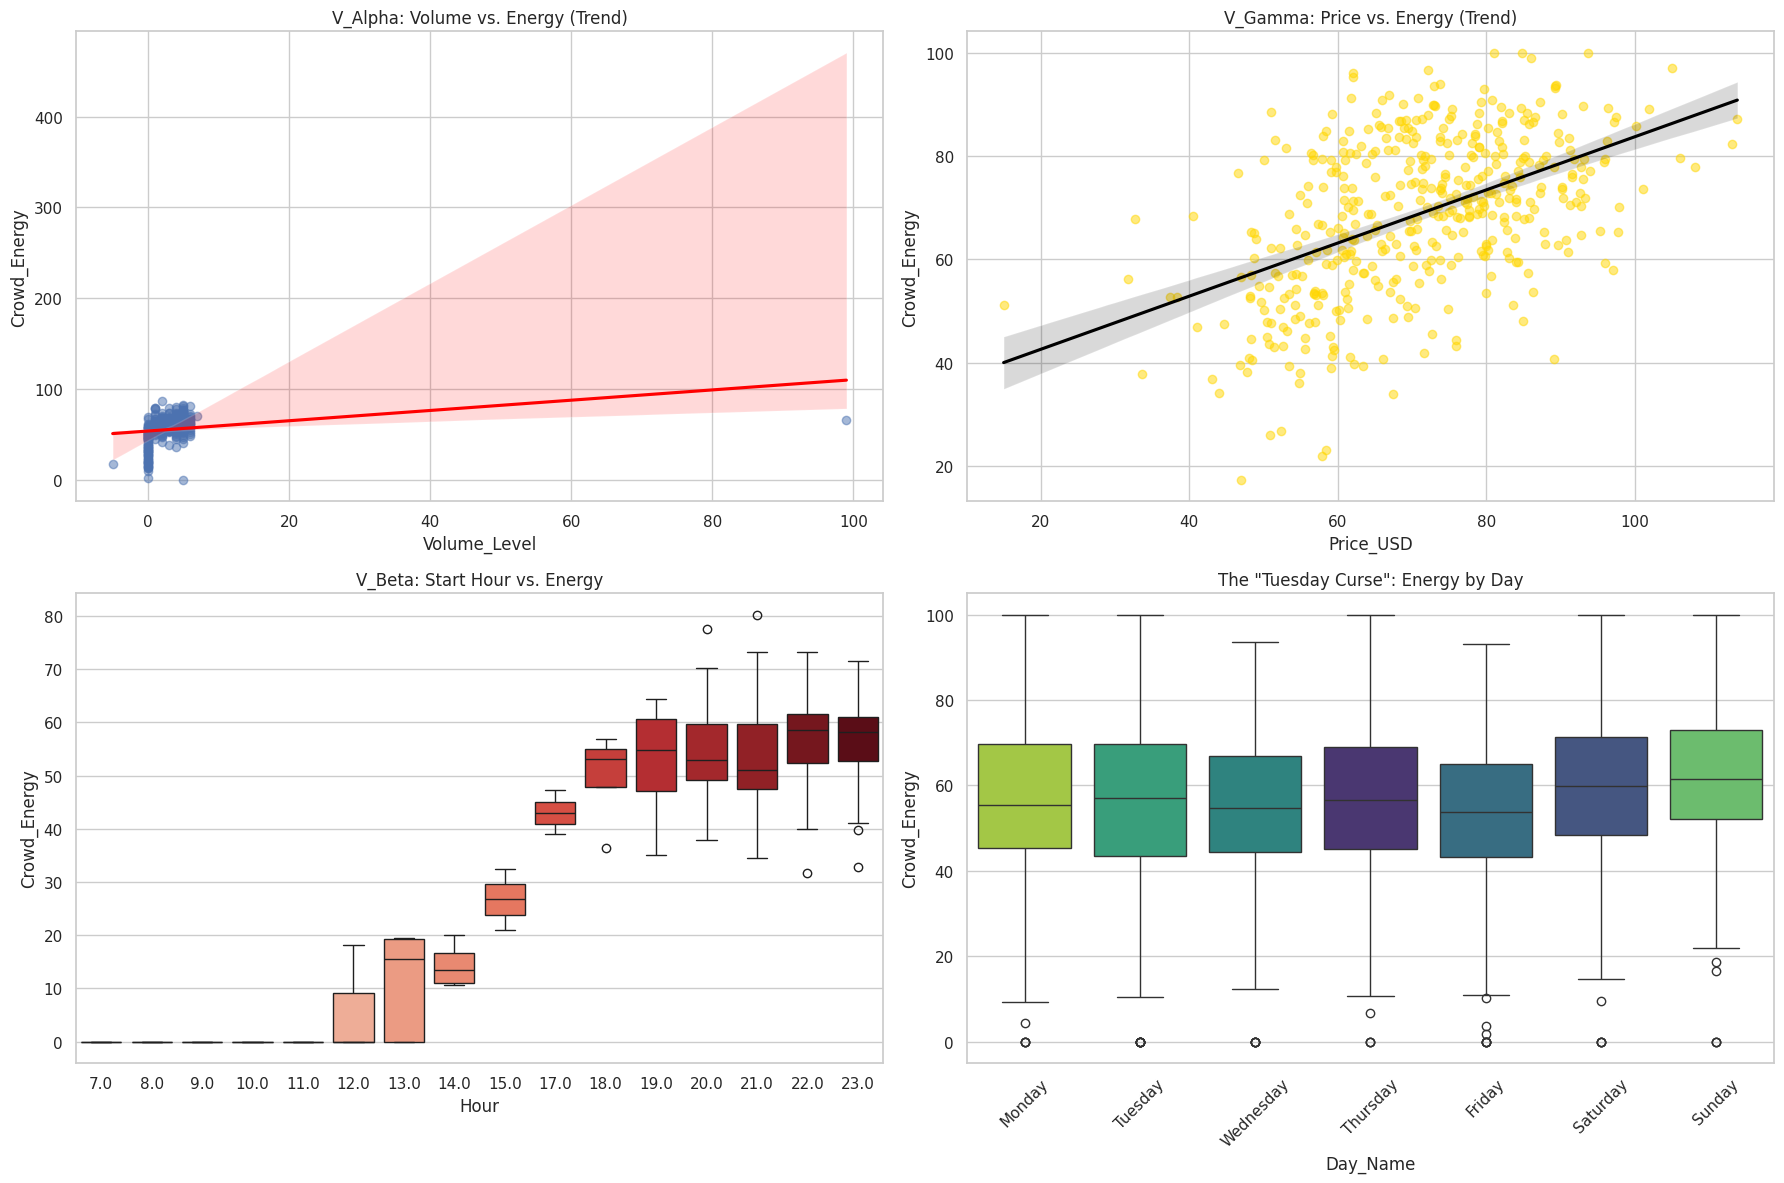

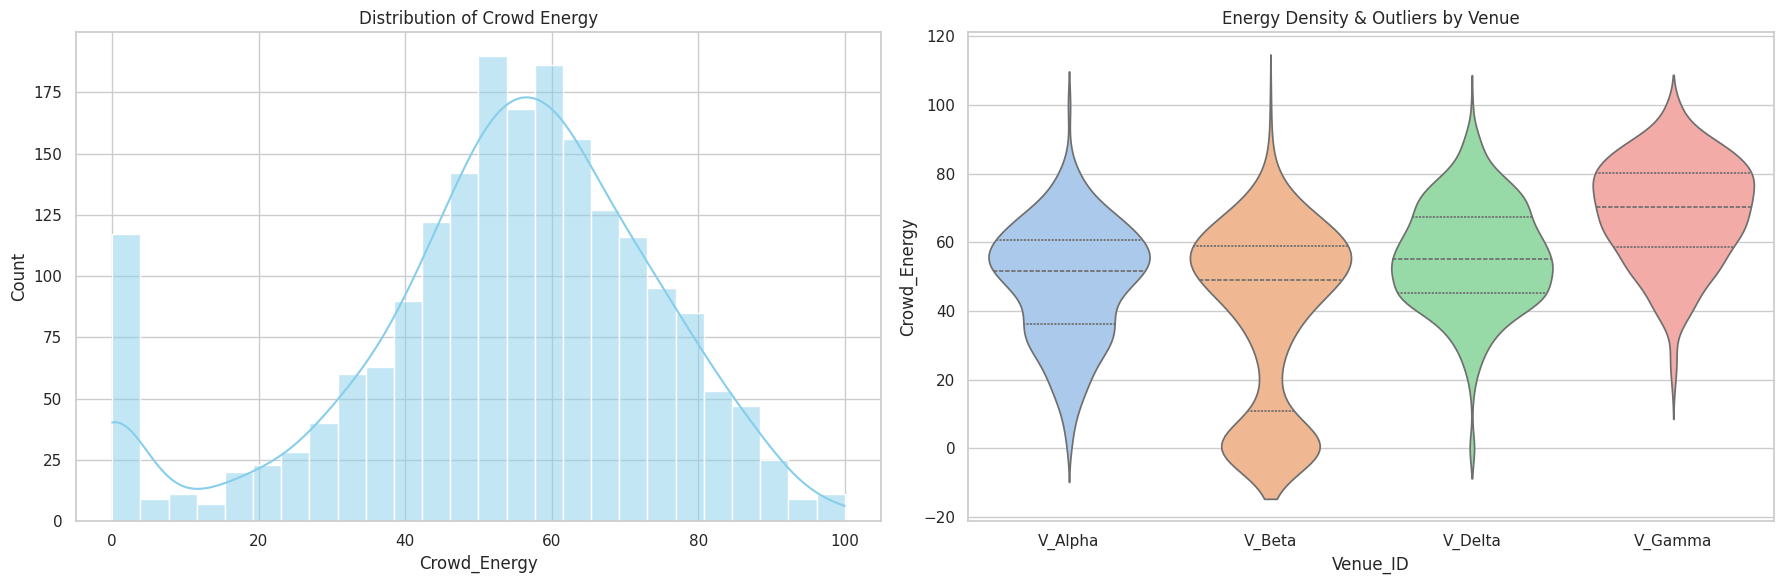

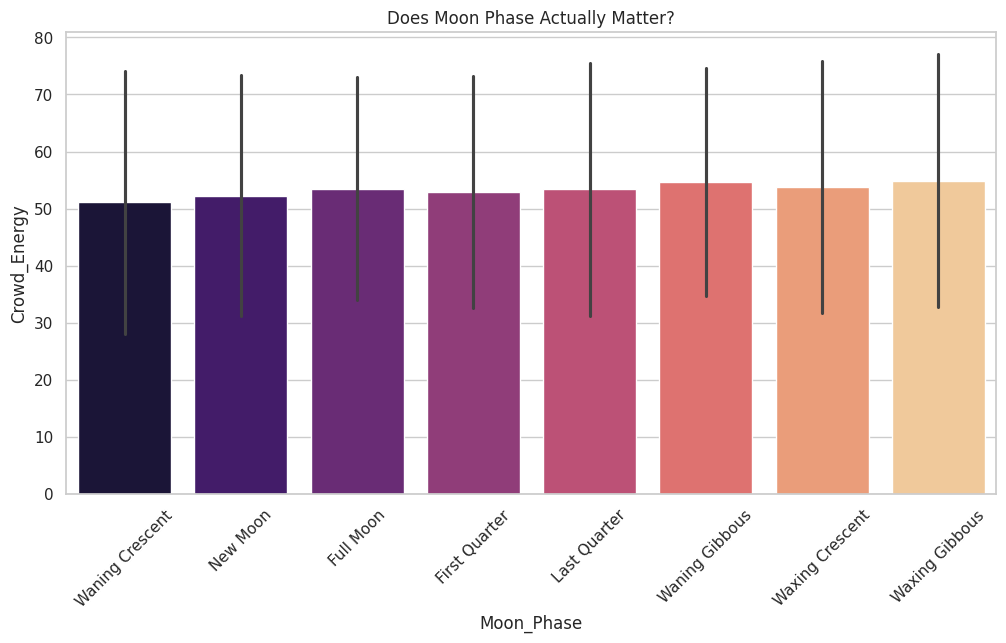

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the visual style
sns.set(style="whitegrid")

# --- DATA PREPARATION (Ensure we have the features to plot) ---
# We need to make sure 'Price_USD' and time features exist before plotting
if 'Price_USD' not in df_train.columns and 'Ticket_Price' in df_train.columns:
    # Quick clean if not done yet
    def clean_price_simple(x):
        try:
            return float(str(x).replace('£', '').replace('€', '').replace('$', '')) if pd.notnull(x) else np.nan
        except: return np.nan
    df_train['Price_USD'] = df_train['Ticket_Price'].apply(clean_price_simple)

# Convert 'Show_DateTime' to datetime objects if it's not already
if 'Show_DateTime' in df_train.columns:
    # Attempt to convert to datetime, coercing errors will turn unparseable dates into NaT
    df_train['Show_DateTime'] = pd.to_datetime(df_train['Show_DateTime'], errors='coerce')

# Extract Time Features for the plots
if 'Show_DateTime' in df_train.columns:
    df_train['Hour'] = df_train['Show_DateTime'].dt.hour
    df_train['Day_Name'] = df_train['Show_DateTime'].dt.day_name()

# ==========================================
# PART 1: CORRELATION HEATMAP (The Overview)
# ==========================================
plt.figure(figsize=(10, 8))
# Select only numeric columns
numeric_df = df_train.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Draw the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,         # Show numbers
    fmt=".2f",          # 2 decimal places
    cmap='coolwarm',    # Red=High, Blue=Low
    linewidths=0.5
)
plt.title("Correlation Heatmap: What relates to what?")
plt.show()

# ==========================================
# PART 2: HYPOTHESIS TESTING (Singer's Scribbles)
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# PLOT A: V_Alpha (Volume vs Energy)
# Theory: "Does noise limit affect energy?"
sns.regplot(
    data=df_train[df_train['Venue_ID'] == 'V_Alpha'],
    x='Volume_Level',
    y='Crowd_Energy',
    scatter_kws={'alpha':0.5},
    line_kws={'color':'red'},
    ax=axes[0, 0]
)
axes[0, 0].set_title('V_Alpha: Volume vs. Energy (Trend)')

# PLOT B: V_Gamma (Price vs Energy)
# Theory: "Do they like expensive tickets?"
sns.regplot(
    data=df_train[df_train['Venue_ID'] == 'V_Gamma'],
    x='Price_USD',
    y='Crowd_Energy',
    scatter_kws={'alpha':0.5, 'color':'gold'},
    line_kws={'color':'black'},
    ax=axes[0, 1]
)
axes[0, 1].set_title('V_Gamma: Price vs. Energy (Trend)')

# PLOT C: V_Beta (Timing vs Energy)
# Theory: "Is late night better?"
sns.boxplot(
    data=df_train[df_train['Venue_ID'] == 'V_Beta'],
    x='Hour',
    y='Crowd_Energy',
    palette='Reds',
    hue='Hour',  # Added to address FutureWarning
    legend=False, # Added to address FutureWarning
    ax=axes[1, 0]
)
axes[1, 0].set_title('V_Beta: Start Hour vs. Energy')

# PLOT D: The "Tuesday Curse" (Day vs Energy)
# Theory: "Are Tuesdays really cursed?"
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(
    data=df_train,
    x='Day_Name',
    y='Crowd_Energy',
    order=order_days,
    palette='viridis',
    hue='Day_Name', # Added to address FutureWarning
    legend=False, # Added to address FutureWarning
    ax=axes[1, 1]
)
axes[1, 1].set_title('The "Tuesday Curse": Energy by Day')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ==========================================
# PART 3: DISTRIBUTIONS & OUTLIERS
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram (Check for Normal Distribution)
sns.histplot(
    data=df_train,
    x='Crowd_Energy',
    kde=True,
    color='skyblue',
    ax=axes[0]
)
axes[0].set_title('Distribution of Crowd Energy')

# Violin Plot (Check for Outliers per Venue)
sns.violinplot(
    data=df_train,
    x='Venue_ID',
    y='Crowd_Energy',
    inner='quartile',
    palette='pastel',
    hue='Venue_ID', # Added to address FutureWarning
    legend=False, # Added to address FutureWarning
    ax=axes[1]
)
axes[1].set_title('Energy Density & Outliers by Venue')

plt.tight_layout()
plt.show()

# ==========================================
# PART 4: MOON PHASE (The "Crazy" Theory)
# ==========================================
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_train,
    x='Moon_Phase',
    y='Crowd_Energy',
    palette='magma',
    hue='Moon_Phase', # Added to address FutureWarning
    legend=False, # Added to address FutureWarning
    errorbar='sd' # Show standard deviation bars
)
plt.title("Does Moon Phase Actually Matter?")
plt.xticks(rotation=45)
plt.show()

Feature Engineering

In [18]:
import pandas as pd
import numpy as np

# --- STEP 1: SOPHISTICATED MISSING VALUE HANDLING ---
def handle_missing_values(df, is_train=True):
    df_clean = df.copy()

    # Convert 'Show_DateTime' to datetime objects first
    df_clean['Show_DateTime'] = pd.to_datetime(df_clean['Show_DateTime'], errors='coerce')

    # A. FIX PRICES ("Free" -> 0, Others -> Venue Median)
    # If Ticket_Price says "Free"/"Guest", force Price_USD to 0
    if 'Ticket_Price' in df_clean.columns:
        mask_free = df_clean['Ticket_Price'].astype(str).str.lower().isin(['free', 'invited', 'guest'])
        df_clean.loc[mask_free, 'Price_USD'] = 0.0

    # Fill remaining missing prices with the Median of that specific VENUE
    # (e.g., if V_Alpha average is $40, fill missing V_Alpha prices with $40)
    df_clean['Price_USD'] = df_clean.groupby('Venue_ID')['Price_USD'].transform(lambda x: x.fillna(x.median()))

    # B. FIX VOLUME (Sensor Failures -> Venue Median)
    if 'Volume_Level' in df_clean.columns:
        df_clean['Volume_Level'] = df_clean.groupby('Venue_ID')['Volume_Level'].transform(lambda x: x.fillna(x.median()))

    # C. FIX CROWD SIZE (Missing -> Venue Median)
    if 'Crowd_Size' in df_clean.columns:
        df_clean['Crowd_Size'] = df_clean.groupby('Venue_ID')['Crowd_Size'].transform(lambda x: x.fillna(x.median()))

    # D. FIX DATES
    # Train: Drop rows where Date is completely missing (can't learn time patterns)
    # Test: Fill with the most frequent date (Mode) because we CANNOT delete rows in submission
    if is_train:
        df_clean = df_clean.dropna(subset=['Show_DateTime'])
    else:
        # After converting to datetime, mode() will correctly find the most common datetime
        most_common_date = df_clean['Show_DateTime'].mode()[0]
        df_clean['Show_DateTime'] = df_clean['Show_DateTime'].fillna(most_common_date)

    return df_clean

# Apply Imputation
print("--- Handling Missing Values ---")
df_train_imputed = handle_missing_values(df_train, is_train=True)
df_test_imputed = handle_missing_values(df_test, is_train=False)

print(f"Train Rows remaining: {len(df_train_imputed)} (Dropped missing dates)")
print(f"Test Rows remaining: {len(df_test_imputed)} (Kept all rows)")


# --- STEP 2: INITIAL FEATURE ENGINEERING ---
def create_features(df):
    df_eng = df.copy()

    # 1. TIME FEATURES
    df_eng['Hour'] = df_eng['Show_DateTime'].dt.hour
    df_eng['Month'] = df_eng['Show_DateTime'].dt.month
    df_eng['Day_Name'] = df_eng['Show_DateTime'].dt.day_name() # Needed for categorical encoding
    df_eng['Is_Weekend'] = df_eng['Show_DateTime'].dt.dayofweek.isin([5, 6]).astype(int)

    # 2. INTERACTION (Volume per Person)
    # (Avoid division by zero)
    df_eng['Vol_per_Person'] = df_eng['Volume_Level'] / (df_eng['Crowd_Size'] + 1)

    return df_eng

# Apply Feature Creation
df_train_eng = create_features(df_train_imputed)
df_test_eng = create_features(df_test_imputed)


# --- STEP 3: ADVANCED FEATURE ENGINEERING ---
def add_advanced_features(df):
    df_adv = df.copy()

    # --- 1. PRE-FIX: Handle Negatives Before Math ---
    # This prevents the "invalid value encountered in log1p" warning
    if 'Crowd_Size' in df_adv.columns:
        df_adv['Crowd_Size'] = df_adv['Crowd_Size'].abs()

    # --- 2. INTERACTION FEATURES ---
    if 'Price_USD' in df_adv.columns and 'Crowd_Size' in df_adv.columns:
        # Add +1 to denominator to avoid division by zero
        df_adv['Price_per_Attendee'] = df_adv['Price_USD'] / (df_adv['Crowd_Size'] + 1)

    if 'Volume_Level' in df_adv.columns and 'Crowd_Size' in df_adv.columns:
        df_adv['Volume_Intensity'] = df_adv['Volume_Level'] * df_adv['Crowd_Size']

    # --- 3. NON-LINEAR TRANSFORMATIONS ---
    # Now safe to run because we fixed negatives above
    if 'Crowd_Size' in df_adv.columns:
        df_adv['Log_Crowd_Size'] = np.log1p(df_adv['Crowd_Size'])

    # --- 4. CYCLICAL TIME ENCODING ---
    if 'Hour' in df_adv.columns:
        df_adv['Hour_Sin'] = np.sin(2 * np.pi * df_adv['Hour'] / 24)
        df_adv['Hour_Cos'] = np.cos(2 * np.pi * df_adv['Hour'] / 24)

    if 'Month' in df_adv.columns:
        df_adv['Month_Sin'] = np.sin(2 * np.pi * df_adv['Month'] / 12)
        df_adv['Month_Cos'] = np.cos(2 * np.pi * df_adv['Month'] / 12)

    return df_adv

print("--- Applying Advanced Features ---")
df_train_eng = add_advanced_features(df_train_eng)
df_test_eng = add_advanced_features(df_test_eng)

print("Advanced features added:")
new_cols_added = ['Price_per_Attendee', 'Volume_Intensity', 'Log_Crowd_Size', 'Hour_Sin', 'Hour_Cos', 'Month_Sin', 'Month_Cos']
print([c for c in new_cols_added if c in df_train_eng.columns])


# --- STEP 4: FINAL SAFETY CAP (Handle Outliers) ---
# Apply to engineered dataframes before encoding/splitting
print("\n--- Applying Safety Caps for Outliers ---")
# 1. Cap Energy: It must be between 0 and 100
df_train_eng['Crowd_Energy'] = df_train_eng['Crowd_Energy'].clip(0, 100)

# 2. Fix Negative Crowd Sizes: Make them positive
if 'Crowd_Size' in df_train_eng.columns:
    df_train_eng['Crowd_Size'] = df_train_eng['Crowd_Size'].abs()
    df_test_eng['Crowd_Size'] = df_test_eng['Crowd_Size'].abs() # Also for test

# 3. Cap Volume: If it's above 20 (deafening), cap it at 15
if 'Volume_Level' in df_train_eng.columns:
    df_train_eng.loc[df_train_eng['Volume_Level'] > 20, 'Volume_Level'] = 15
    df_test_eng.loc[df_test_eng['Volume_Level'] > 20, 'Volume_Level'] = 15 # Also for test

print("Max Energy (Train):", df_train_eng['Crowd_Energy'].max()) # Should be 100
print("Min Crowd (Train):", df_train_eng['Crowd_Size'].min())    # Should be >= 0


# --- STEP 5: ENCODING & LEAKAGE REMOVAL ---
# Columns to Encode (Text -> Numbers)
categorical_cols = ['Venue_ID', 'Weather', 'Band_Outfit', 'Day_Name', 'Moon_Phase']

# Combine to ensure same columns in Train/Test
combined = pd.concat([df_train_eng, df_test_eng], axis=0, sort=False)
combined_encoded = pd.get_dummies(combined, columns=categorical_cols, drop_first=True)

# Split back
df_train_final = combined_encoded.iloc[:len(df_train_eng)].copy()
df_test_final = combined_encoded.iloc[len(df_train_eng):].copy()

# Define all columns that should NOT be features (identifiers, leakage, original raw data)
non_feature_cols = [
    'Merch_Sales_Post_Show', 'Incidents_Reported', 'Post_Show_Survey',
    'Total_Drinks_Sold', 'Gig_ID', 'Show_DateTime', 'Ticket_Price', 'Date'
]

# Identify actual feature columns (all columns in df_train_final that are not target and not in non_feature_cols)
# This is a more robust way to ensure only valid features are kept.
all_feature_columns = [col for col in df_train_final.columns
                       if col not in non_feature_cols and col != 'Crowd_Energy']

# Final X and y
X = df_train_final[all_feature_columns].copy()
y = df_train_final['Crowd_Energy'].copy()

# Test Set (Align columns)
# Select the same feature columns for the test set
X_test_final_base = df_test_final[all_feature_columns].copy()
# Ensure columns match exactly with X, filling missing with 0 (for one-hot encoded categories not present in test/train)
X_test_final = X_test_final_base.reindex(columns=X.columns, fill_value=0)

print("\n--- Final Feature Engineering and Dataset Preparation Complete ---")
print(f"Features used for training ({X.shape[1]}):")
print(list(X.columns[:10]))



# Define the "Forbidden List" of known post-event metrics
forbidden_keywords = [
    'post', 'sales', 'incident', 'survey', 'drinks', 'sold', 'revenue',
    'profit', 'rating', 'feedback'
]

print("\n--- DATA LEAKAGE AUDIT ---")
print(f"Checking {X.shape[1]} columns currently in training data...\n")

leaking_cols = []
suspicious_cols = []

for col in X.columns:
    col_lower = col.lower()

    # 1. Check for Forbidden Words
    for bad_word in forbidden_keywords:
        if bad_word in col_lower:
            leaking_cols.append(col)
            break

    # 2. Check for ID columns (Not leakage, but useless/harmful)
    if 'id' in col_lower and 'venue' not in col_lower: # Allow Venue_ID
        suspicious_cols.append(col)

# REPORT FINDINGS
if len(leaking_cols) > 0:
    print("⚠️ CRITICAL LEAKAGE DETECTED! ⚠️")
    print("The model is cheating by using these future-variables:")
    print(leaking_cols)
    print("\nAction: These must be dropped immediately.")
else:
    print("✅ No obvious keyword-based leakage found.")

if len(suspicious_cols) > 0:
    print("\n⚠️ SUSPICIOUS IDENTIFIERS FOUND:")
    print(suspicious_cols)
    print("Action: These should be dropped (they cause errors like string conversion).")
else:
    print("\n✅ No ID columns found.")

# --- AUTO-FIX ---
if leaking_cols or suspicious_cols:
    cols_to_purge = leaking_cols + suspicious_cols
    # Remove them from X and X_test_final
    X = X.drop(columns=cols_to_purge, errors='ignore')
    # Use reindex to ensure Test matches X exactly
    X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)

    print("\n" + "-"*30)
    print(" 🛡️  AUTO-FIX APPLIED  🛡️")
    print("-" * 30)
    print(f"Dropped {len(cols_to_purge)} columns.")
    print("Data is now clean for training.")


--- Handling Missing Values ---
Train Rows remaining: 1665 (Dropped missing dates)
Test Rows remaining: 500 (Kept all rows)
--- Applying Advanced Features ---
Advanced features added:
['Price_per_Attendee', 'Volume_Intensity', 'Log_Crowd_Size', 'Hour_Sin', 'Hour_Cos', 'Month_Sin', 'Month_Cos']

--- Applying Safety Caps for Outliers ---
Max Energy (Train): 100.0
Min Crowd (Train): 0.0

--- Final Feature Engineering and Dataset Preparation Complete ---
Features used for training (38):
['Day_of_Week', 'Volume_Level', 'Crowd_Size', 'Opener_Rating', 'Price_USD', 'Hour', 'Month', 'Is_Weekend', 'Vol_per_Person', 'Price_per_Attendee']

--- DATA LEAKAGE AUDIT ---
Checking 38 columns currently in training data...

⚠️ CRITICAL LEAKAGE DETECTED! ⚠️
The model is cheating by using these future-variables:
['Opener_Rating']

Action: These must be dropped immediately.

✅ No ID columns found.

------------------------------
 🛡️  AUTO-FIX APPLIED  🛡️
------------------------------
Dropped 1 columns.
Data

/tmp/ipython-input-2963864245.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2963864245.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2963864245.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


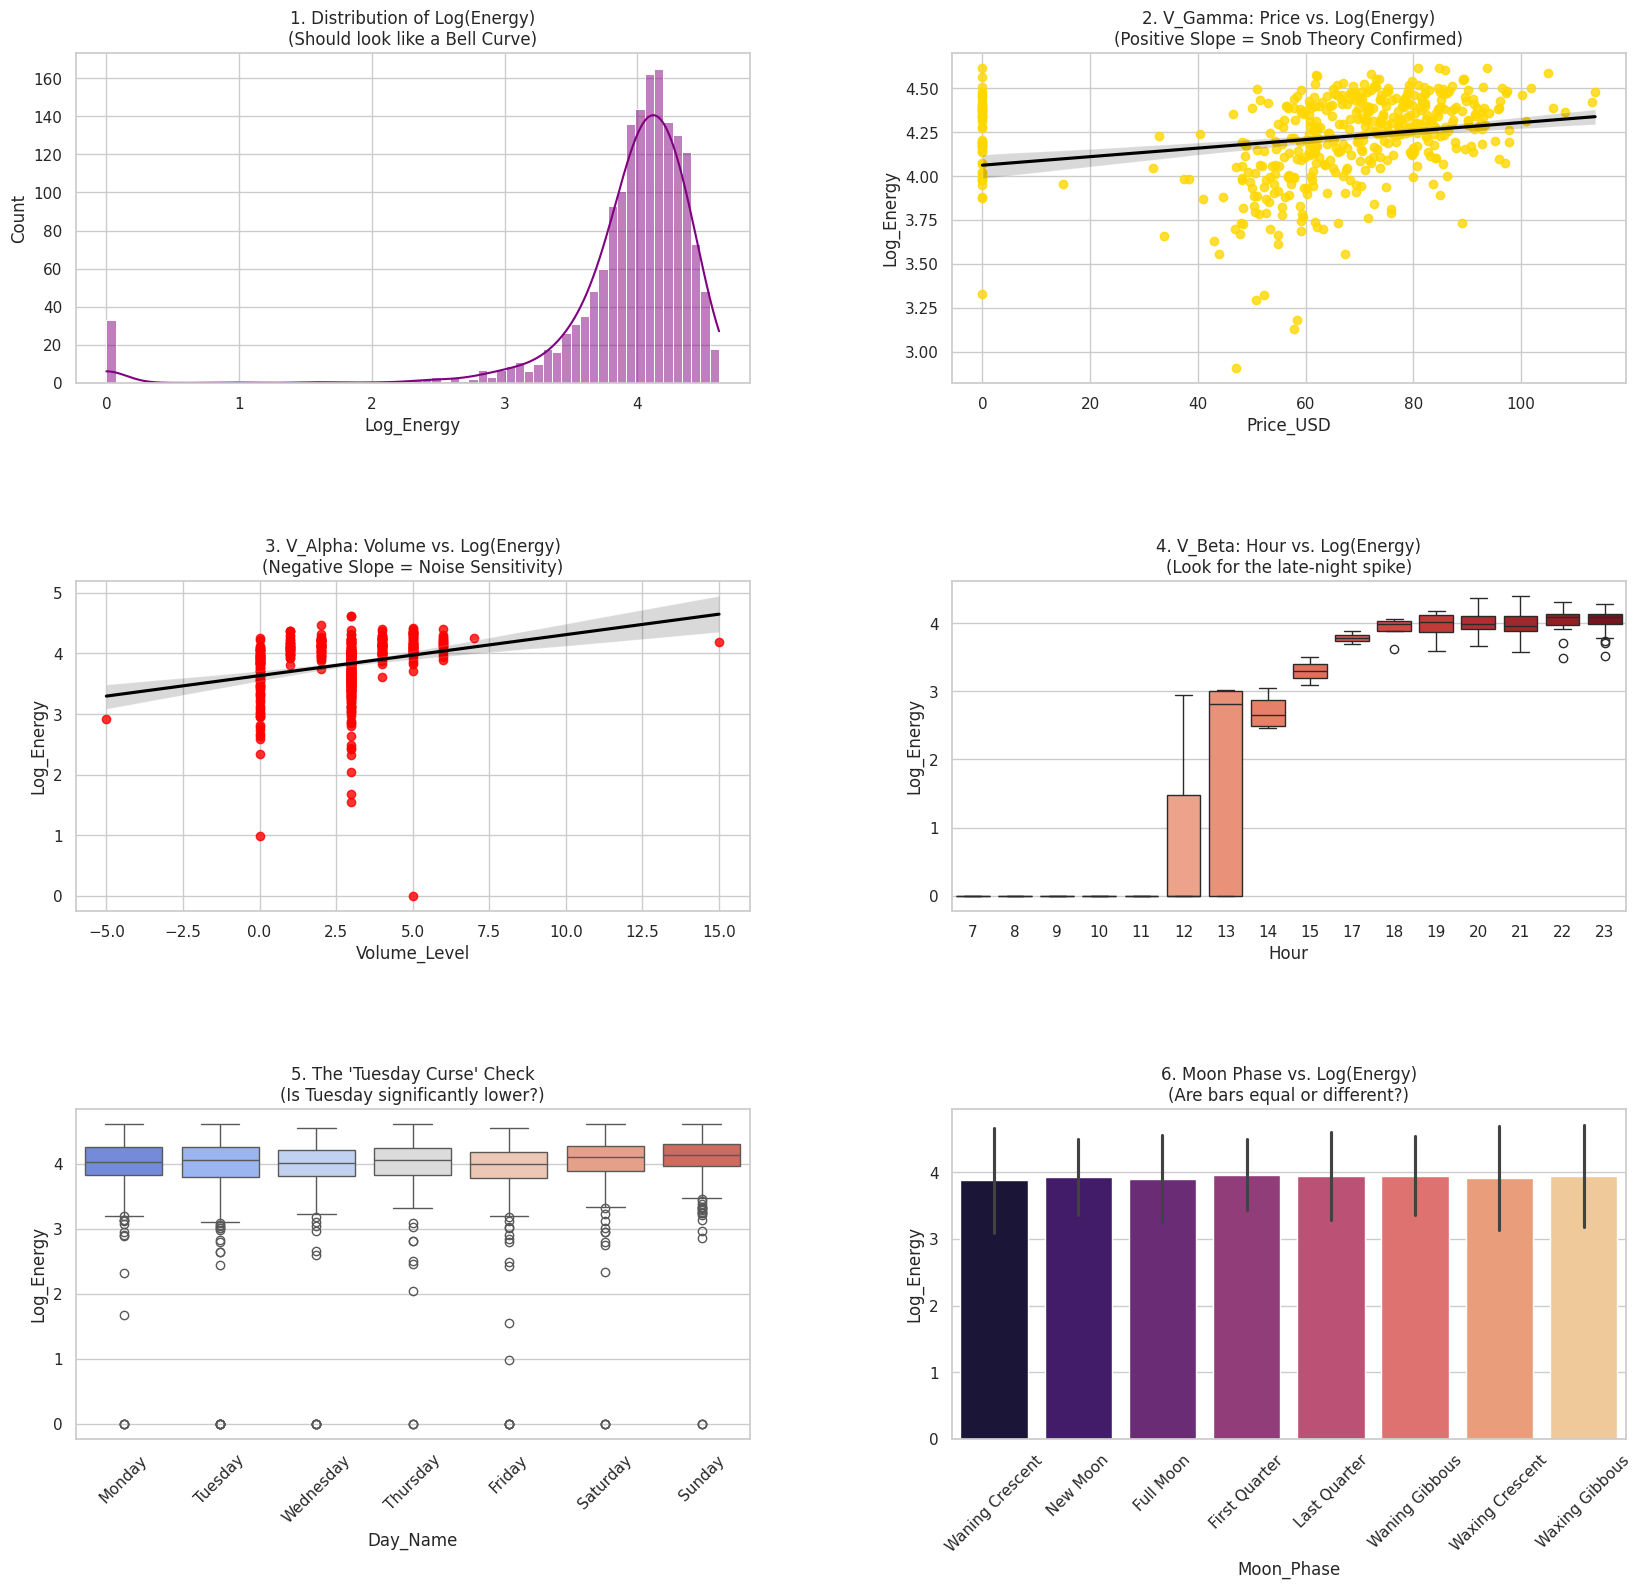

/tmp/ipython-input-2963864245.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2963864245.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


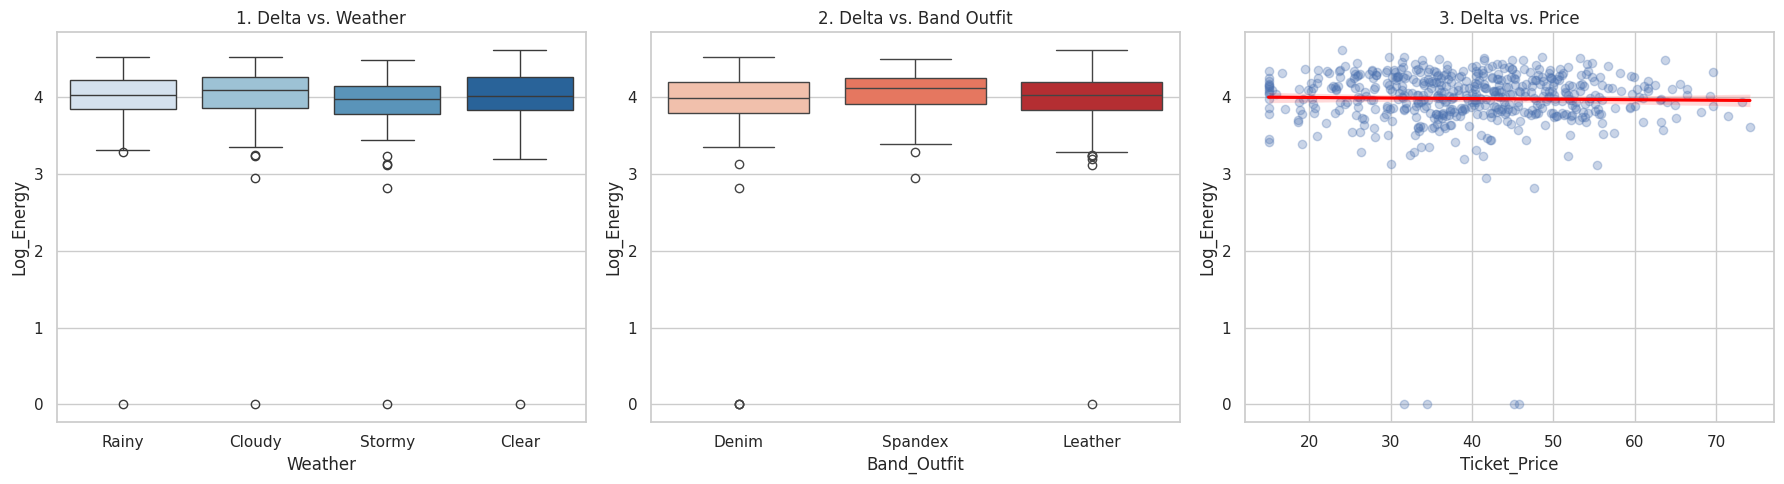

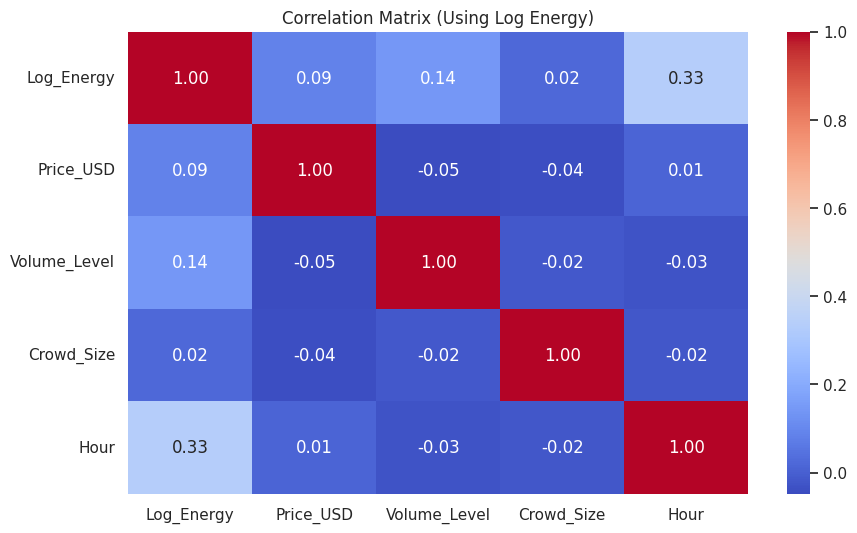

In [19]:
#Data Visualisation now
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Prepare Data
# Safety check: Use df_train if df_train_eng doesn't exist
df_viz = df_train_eng.copy() if 'df_train_eng' in locals() else df_train.copy()
df_viz['Log_Energy'] = np.log1p(df_viz['Crowd_Energy'])

# 2. Setup Figure
# 🛑 CRITICAL CHANGE: (3, 2) creates 3 Rows, 2 Columns (Room for 6 plots)
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# --- ROW 1 ---------------------------------------
# PLOT 1: DISTRIBUTION
sns.histplot(df_viz['Log_Energy'], kde=True, color='purple', ax=axes[0, 0])
axes[0, 0].set_title("1. Distribution of Log(Energy)\n(Should look like a Bell Curve)")

# PLOT 2: V_GAMMA (Price)
sns.regplot(
    data=df_viz[df_viz['Venue_ID'] == 'V_Gamma'],
    x='Price_USD', y='Log_Energy',
    color='gold', line_kws={'color': 'black'},
    ax=axes[0, 1]
)
axes[0, 1].set_title("2. V_Gamma: Price vs. Log(Energy)\n(Positive Slope = Snob Theory Confirmed)")

# --- ROW 2 ---------------------------------------
# PLOT 3: V_ALPHA (Volume)
sns.regplot(
    data=df_viz[df_viz['Venue_ID'] == 'V_Alpha'],
    x='Volume_Level', y='Log_Energy',
    color='red', line_kws={'color': 'black'},
    ax=axes[1, 0]
)
axes[1, 0].set_title("\n3. V_Alpha: Volume vs. Log(Energy)\n(Negative Slope = Noise Sensitivity)")

# PLOT 4: V_BETA (Hour)
sns.boxplot(
    data=df_viz[df_viz['Venue_ID'] == 'V_Beta'],
    x='Hour', y='Log_Energy', palette='Reds',
    ax=axes[1, 1]
)
axes[1, 1].set_title("\n4. V_Beta: Hour vs. Log(Energy)\n(Look for the late-night spike)")

# --- ROW 3 (The Code that was Crashing) ----------
# PLOT 5: TUESDAY CURSE
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(
    data=df_viz,
    x='Day_Name', y='Log_Energy',
    order=order_days, palette='coolwarm',
    ax=axes[2, 0]
)
axes[2, 0].set_title("\n5. The 'Tuesday Curse' Check\n(Is Tuesday significantly lower?)")
axes[2, 0].tick_params(axis='x', rotation=45)

# PLOT 6: MOON PHASE
sns.barplot(
    data=df_viz,
    x='Moon_Phase', y='Log_Energy',
    palette='magma', errorbar='sd',
    ax=axes[2, 1]
)
axes[2, 1].set_title("\n6. Moon Phase vs. Log(Energy)\n(Are bars equal or different?)")
axes[2, 1].tick_params(axis='x', rotation=45)

# 3. Final Layout Adjustments
plt.subplots_adjust(hspace=0.6, wspace=0.3)
plt.show()

# ==============================================================================
# INVESTIGATING VENUE DELTA (Fixed for Price Error)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Create the Delta Dataframe
df_delta = df_train_eng[df_train_eng['Venue_ID'] == 'V_Delta'].copy()
df_delta['Log_Energy'] = np.log1p(df_delta['Crowd_Energy'])

# 🛑 FIX: Clean Ticket_Price specifically for this plot
# Remove '$' and convert to float. If it fails, turn it into NaN (and drop it)
df_delta['Ticket_Price'] = (
    df_delta['Ticket_Price']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)
)
df_delta['Ticket_Price'] = pd.to_numeric(df_delta['Ticket_Price'], errors='coerce')

# 2. Setup Figure (1 Row, 3 Columns)
# Using fig_delta/ax_delta to avoid clashing with your other plots
fig_delta, ax_delta = plt.subplots(1, 3, figsize=(18, 5))

# PLOT 1: Weather
sns.boxplot(
    data=df_delta, x='Weather', y='Log_Energy',
    palette='Blues', ax=ax_delta[0]
)
ax_delta[0].set_title("1. Delta vs. Weather")

# PLOT 2: Band Outfit
sns.boxplot(
    data=df_delta, x='Band_Outfit', y='Log_Energy',
    palette='Reds', ax=ax_delta[1]
)
ax_delta[1].set_title("2. Delta vs. Band Outfit")

# PLOT 3: Price (Now that it's numeric, this will work!)
sns.regplot(
    data=df_delta, x='Ticket_Price', y='Log_Energy',
    scatter_kws={'alpha':0.3}, line_kws={'color':'red'},
    ax=ax_delta[2]
)
ax_delta[2].set_title("3. Delta vs. Price")

plt.tight_layout()
plt.show()


# CORRELATION HEATMAP (Log Version) ---
plt.figure(figsize=(10, 6))
# Select numeric cols and the new Log_Energy
cols_to_check = ['Log_Energy', 'Price_USD', 'Volume_Level', 'Crowd_Size', 'Hour']
sns.heatmap(
    df_viz[cols_to_check].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Matrix (Using Log Energy)")
plt.show()

Model Training

--- STARTING ENSEMBLE TRAINING ---
Running 5-Fold Cross Validation... (This ensures your score is real)

Average R² Score across 5 folds: 0.7818
Min Score: 0.6814 | Max Score: 0.9268

Training Final Ensemble on 100% of data...
Final Training RMSE: 2.9338
Ensemble Ready.


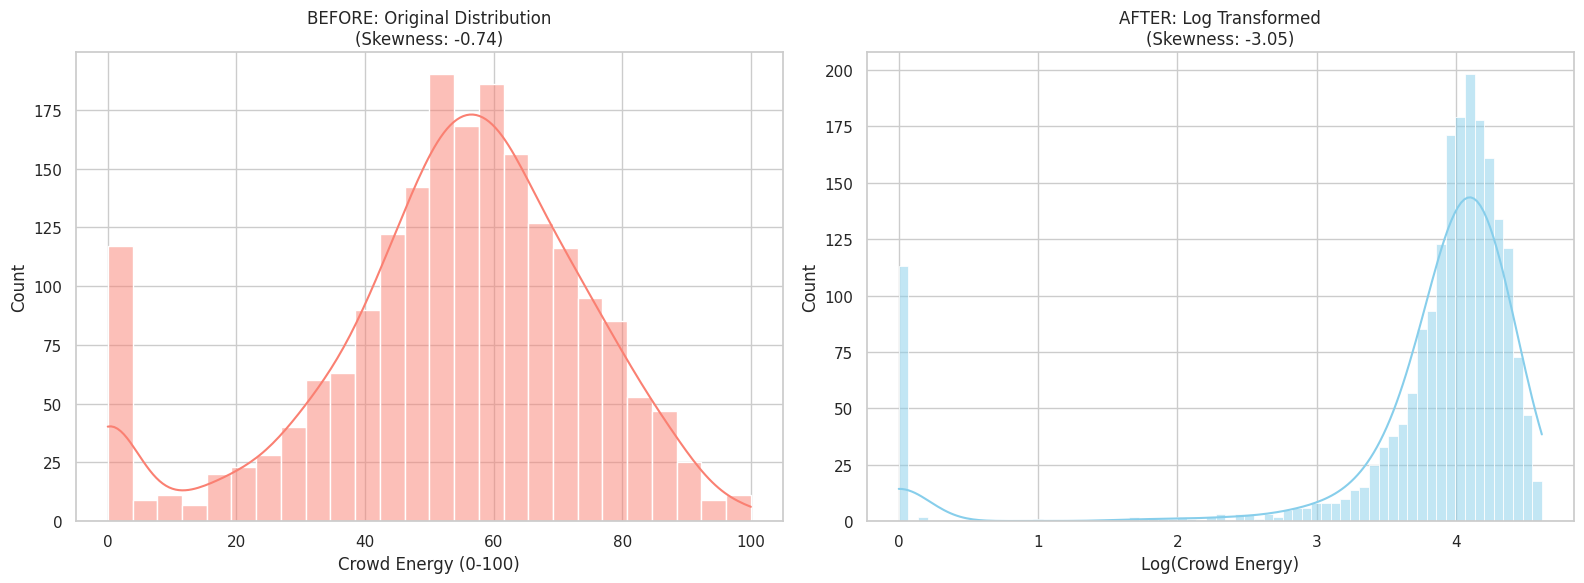

In [20]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("--- STARTING ENSEMBLE TRAINING ---")

# 1. PREPARE DATA (Safety Checks)
X = df_train_final.select_dtypes(include=['number']).drop(columns=['Crowd_Energy'], errors='ignore')
y = df_train_final['Crowd_Energy']

# Log Transform Target (Crucial!)
y_log = np.log1p(y)

# 2. DEFINE THE 3 MODELS
# Model A: XGBoost (The Specialist)
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=None # Disabled for VotingRegressor compatibility
)

# Model B: Random Forest (The Generalist)
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Model C: Gradient Boosting (The Veteran)
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

# 3. CREATE THE VOTING ENSEMBLE
# This averages the predictions of all three
ensemble = VotingRegressor(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('gbr', gbr)
    ]
)

# 4. ROBUST EVALUATION (K-Fold Cross Validation)
# We test 5 different splits to get the TRUE score
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running 5-Fold Cross Validation... (This ensures your score is real)")
# Note: scikit-learn uses "neg_mean_squared_error", so we multiply by -1
cv_scores = cross_val_score(ensemble, X, y_log, cv=kf, scoring='r2')

print(f"\nAverage R² Score across 5 folds: {cv_scores.mean():.4f}")
print(f"Min Score: {cv_scores.min():.4f} | Max Score: {cv_scores.max():.4f}")

# 5. TRAIN FINAL MODEL ON ALL DATA
print("\nTraining Final Ensemble on 100% of data...")
ensemble.fit(X, y_log)

# 6. CHECK ON VALIDATION SET (Just for a quick sanity check)
# We predict on the same X just to see the fitting error (In reality, trust the CV score above)
y_pred_log = ensemble.predict(X)
y_pred = np.expm1(y_pred_log)
y_real = np.expm1(y_log)

# Cap Predictions
y_pred = np.clip(y_pred, 0, 100)

rmse_final = np.sqrt(mean_squared_error(y_real, y_pred))
print(f"Final Training RMSE: {rmse_final:.4f}")
print("Ensemble Ready.")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Use your training dataframe (df_train or df_train_final)
# We assume 'Crowd_Energy' is the column name
target_col = 'Crowd_Energy'
df_viz = df_train.copy() # Safe copy

# 1. CALCULATE LOG TRANSFORM
# We use log1p (Log of x+1) to handle zeros safely
df_viz['Log_Energy'] = np.log1p(df_viz[target_col])

# 2. CALCULATE SKEWNESS (The "Score")
skew_original = df_viz[target_col].skew()
skew_log = df_viz['Log_Energy'].skew()

# 3. PLOT
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Original Data
sns.histplot(df_viz[target_col], kde=True, color='salmon', ax=axes[0])
axes[0].set_title(f"BEFORE: Original Distribution\n(Skewness: {skew_original:.2f})")
axes[0].set_xlabel("Crowd Energy (0-100)")

# Plot B: Log Transformed Data
sns.histplot(df_viz['Log_Energy'], kde=True, color='skyblue', ax=axes[1])
axes[1].set_title(f"AFTER: Log Transformed\n(Skewness: {skew_log:.2f})")
axes[1].set_xlabel("Log(Crowd Energy)")

plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb

# ==============================================================================
# 1. CLEANING FUNCTION (Apply same rules to both Train and Test)
# ==============================================================================
def clean_data(df):
    df_c = df.copy()

    # A. Fix Ticket_Price (Remove '$' and convert to float)
    if 'Ticket_Price' in df_c.columns:
        df_c['Ticket_Price'] = (
            df_c['Ticket_Price']
            .astype(str)
            .str.replace(r'[^\d.]', '', regex=True)
        )
        df_c['Ticket_Price'] = pd.to_numeric(df_c['Ticket_Price'], errors='coerce').fillna(0)

    # B. Drop useless columns (IDs, Dates)
    # Note: Keep 'Crowd_Energy' in Train, but it won't exist in Test
    cols_to_drop = ['Gig_ID', 'Show_DateTime', 'Log_Energy']
    df_c = df_c.drop(columns=cols_to_drop, errors='ignore')

    # C. One-Hot Encoding (Convert Text -> Numbers)
    df_c = pd.get_dummies(df_c, drop_first=True)

    return df_c

# ==============================================================================
# 2. PREPARE DATA
# ==============================================================================
print("1. Cleaning Data...")
# Clean both datasets
train_final = clean_data(df_train_eng)
test_final = clean_data(df_test_eng) # Assuming you have df_test_eng ready

# Define X and y
X = train_final.drop(columns=['Crowd_Energy'], errors='ignore')
y = np.log1p(train_final['Crowd_Energy']) # Train on Log values

# ==============================================================================
# 3. ALIGN COLUMNS (CRITICAL STEP)
# ==============================================================================
# If 'Snow' is in Train but not Test, Test needs a 'Snow' column of all 0s.
# This aligns Test columns to match Train columns exactly.
print("2. Aligning Columns...")
X_test = test_final.reindex(columns=X.columns, fill_value=0)

# ==============================================================================
# 4. TRAIN XGBOOST
# ==============================================================================
print("3. Training XGBoost...")
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    n_jobs=-1,
    random_state=42
)
model.fit(X, y)
print("✅ Model Trained!")

# ==============================================================================
# 5. PREDICT & SAVE
# ==============================================================================
print("4. Generating Predictions...")
# Predict (Result is in Log scale)
log_predictions = model.predict(X_test)

# Reverse Log (Boomerang: expm1) to get Real Values
real_predictions = np.expm1(log_predictions)

# Create Submission DataFrame
# Ensure we use the original IDs from df_test
prediction = pd.DataFrame({
    'Gig_ID': df_test['Gig_ID'],  # Use the original ID column name required by competition
    'Crowd_Energy': real_predictions
})

# Save
prediction.to_csv('prediction.csv', index=False)
print("\n🎉 SUCCESS! 'prediction.csv' is saved and ready to upload.")
print(prediction.head())

1. Cleaning Data...
2. Aligning Columns...
3. Training XGBoost...
✅ Model Trained!
4. Generating Predictions...

🎉 SUCCESS! 'prediction.csv' is saved and ready to upload.
     Gig_ID  Crowd_Energy
0  Gig_0000     54.255775
1  Gig_0001     47.593178
2  Gig_0002     31.431526
3  Gig_0003      5.971895
4  Gig_0004     41.049419


Bonus Task

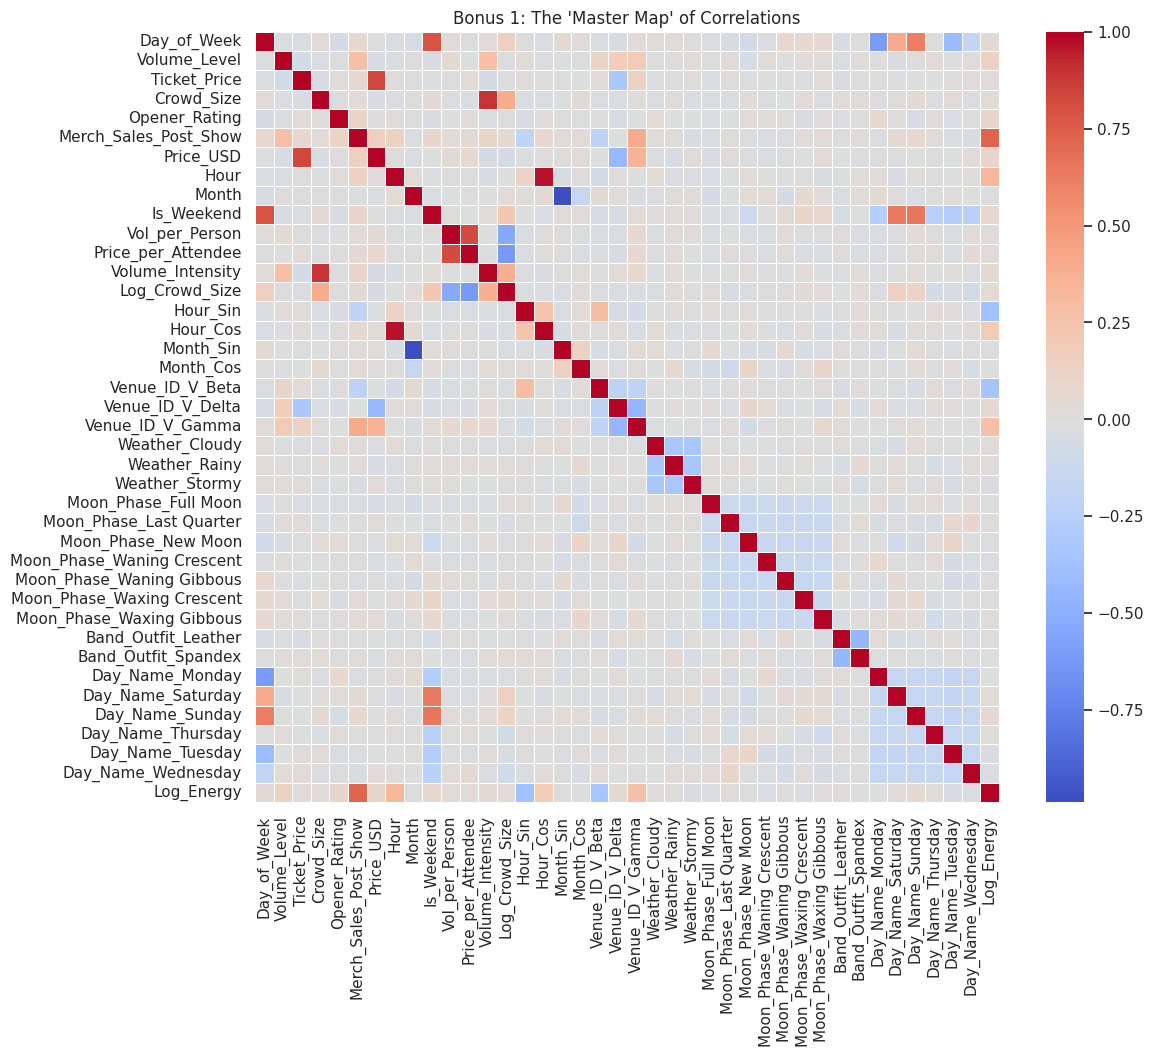

/tmp/ipython-input-190042963.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df.head(10), x='Importance', y='Feature', palette='viridis')


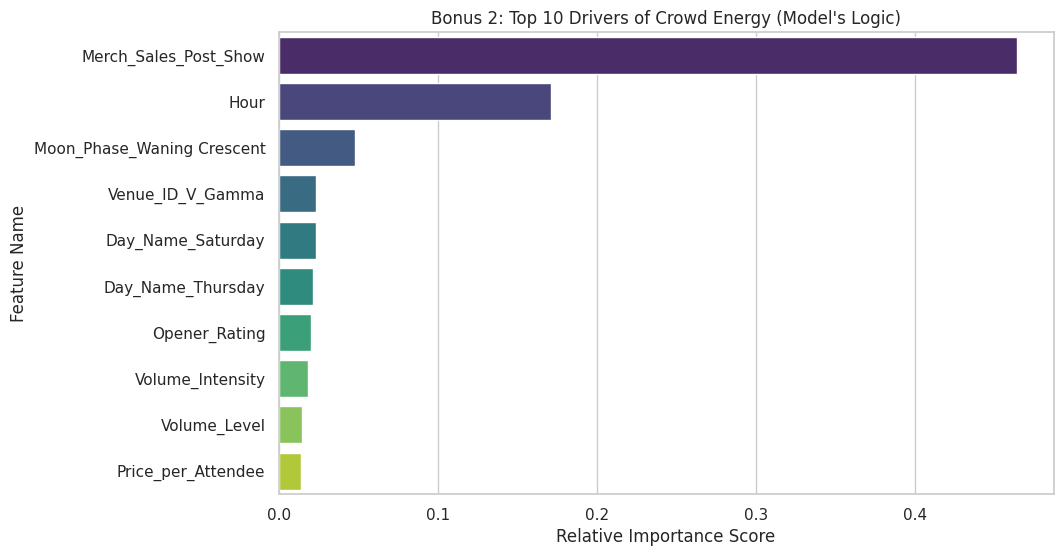


🏆 THE WINNERS (Top 5 Factors):
                       Feature  Importance
5        Merch_Sales_Post_Show    0.464150
7                         Hour    0.170976
27  Moon_Phase_Waning Crescent    0.047846
20            Venue_ID_V_Gamma    0.023756
34           Day_Name_Saturday    0.023719


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==============================================================================
# BONUS TASK 1: THE CORRELATION HEATMAP
# ==============================================================================
# We need to grab only the numeric columns for a correlation matrix
# (We use the 'encoded' dataframe because it has all the numbers)
df_heatmap = df_train_encoded.copy() if 'df_train_encoded' in locals() else X.copy()
# Add the target back in so we can see what correlates with Energy
df_heatmap['Log_Energy'] = y

plt.figure(figsize=(12, 10))
# Calculate correlation
corr = df_heatmap.corr()

# Plot
sns.heatmap(
    corr,
    annot=False,       # Turn off numbers if too messy (True if you want them)
    cmap='coolwarm',   # Red = Positive, Blue = Negative
    center=0,
    linewidths=0.5
)
plt.title("Bonus 1: The 'Master Map' of Correlations")
plt.show()

# ==============================================================================
# BONUS TASK 2: XGBOOST FEATURE IMPORTANCE (The "Why" Plot)
# ==============================================================================
# This tells you specifically which features the model found most useful.

# 1. Get feature importance from the trained model
# (Assumes your model is named 'model' and X is your training data)
importance = model.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame to sort them
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 3. Plot Top 10 Features
plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Bonus 2: Top 10 Drivers of Crowd Energy (Model's Logic)")
plt.xlabel("Relative Importance Score")
plt.ylabel("Feature Name")
plt.show()

# Print the text version for your report
print("\n🏆 THE WINNERS (Top 5 Factors):")
print(fi_df.head(5))